In [2]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu
from suite3d import nbtools as nbui
from suite3d import extension as ext

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [74]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'TC030',
    'date' :          '2025-01-23',
    'expnum' :         [4],}
n_planes = 9
original_tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False, get_si_params=False)

data_dir = '/mnt/md0/data/' + exp_str

os.makedirs(data_dir, exist_ok=True)

In [80]:
n_leftover_planes = 0
leftover_planes = None
tifs = []
for tif_idx, tif in enumerate(original_tifs):
    dir_idx = tif.split('/')[-2]
    save_dir = os.path.join(data_dir, dir_idx)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir,f"{tif_idx:05d}.tiff")
    tf = tifffile.TiffFile(tif)
    n_planes_tif = len(tf.pages)
    n_first_planes = (n_planes - n_leftover_planes) % n_planes
    
    
    n_full_frames = (n_planes_tif - n_first_planes) // n_planes
    n_new_leftovers = (n_planes_tif - n_first_planes) % n_planes

    all_frames = tf.asarray()

    if n_leftover_planes > 0:
        all_frames = n.concatenate([leftover_planes, all_frames],axis=0)

    full_frames = all_frames[:n_planes_tif+n_leftover_planes-n_new_leftovers]
    leftover_planes = all_frames[n_planes_tif+n_leftover_planes-n_new_leftovers:]

    print(f"Tif {tif_idx:03d} has {n_planes_tif} planes. Path: {tif}")
    print(f"First {n_first_planes} planes complete the {n_leftover_planes} from the previous tif to form a full frame")
    
    n_leftover_planes = n_new_leftovers
    print(f"Of the remaining {n_planes_tif - n_first_planes}, we complete {n_full_frames} frames with {n_full_frames * n_planes} planes")
    print(f"This leaves {n_leftover_planes} planes to be completed by the next tif")
    mov = full_frames.reshape(-1, *full_frames.shape[1:])
    print(f"Saving movie of shape {mov.shape} to {save_path}")
    tifffile.imsave(save_path, mov, dtype=mov.dtype)
    tifs.append(save_path)

Tif 000 has 2000 planes. Path: /mnt/zortex-subjects/TC030/2025-01-23/4/2025-01-23_4_TC030_2P_00001_00001.tif
First 0 planes complete the 0 from the previous tif to form a full frame
Of the remaining 2000, we complete 222 frames with 1998 planes
This leaves 2 planes to be completed by the next tif
Saving movie of shape (1998, 512, 512) to /mnt/md0/data/TC030_2025-01-23_4/4/00000.tiff
Tif 001 has 2000 planes. Path: /mnt/zortex-subjects/TC030/2025-01-23/4/2025-01-23_4_TC030_2P_00001_00002.tif
First 7 planes complete the 2 from the previous tif to form a full frame
Of the remaining 1993, we complete 221 frames with 1989 planes
This leaves 4 planes to be completed by the next tif
Saving movie of shape (1998, 512, 512) to /mnt/md0/data/TC030_2025-01-23_4/4/00001.tiff
Tif 002 has 2000 planes. Path: /mnt/zortex-subjects/TC030/2025-01-23/4/2025-01-23_4_TC030_2P_00001_00003.tif
First 5 planes complete the 4 from the previous tif to form a full frame
Of the remaining 1995, we complete 221 frames 

In [81]:

vol_rate = 30 / 9

job_params = {   
    'lbm' : False,
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 9,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.arange(n_planes),
    'multiplane_2p_use_planes' : n.array([2,3,4,5,6, 7, 8]),
    # number of files to use for the initial pass
    'n_init_files' :   3,

    # volume rate in acquisition
    'fs' : vol_rate,
    'lbm' : False,
    'subtract_crosstalk' : False,
    'fuse_strips' : False,
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
}


savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-TC030_2025-01-23_4 already exists
Loading job directory for TC030_2025-01-23_4 in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param lbm
      Updating param n_ch_tif
      Updating param planes
      Updating param multiplane_2p_use_planes
      Updating param n_init_files
      Updating param fs
      Updating param subtract_crosstalk
      Updating param fuse_strips
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [82]:
job.run_init_pass()

   Saved a copy of params at /mnt/md0/runs/s3d-TC030_2025-01-23_4/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-TC030_2025-01-23_4/summary/summary.npy
   Loading init tifs with 9 channels
      Loading tiff 1/3: /mnt/md0/data/TC030_2025-01-23_4/4/00002.tiff
      Loading tiff 2/3: /mnt/md0/data/TC030_2025-01-23_4/4/00004.tiff
      Loading tiff 3/3: /mnt/md0/data/TC030_2025-01-23_4/4/00006.tiff
   Loaded 3 files, total 2.28 GB
   Loaded movie with 667 frames and shape 7, 512, 512
      Enforcing positivity in mean image
   No crosstalk estimation or subtraction
   Using 3d registration
   Computing plane alignment shifts
   Applying plane alignment shifts
   Launching 3D GPU reference image calculation
      Seeding reference image with most active frames
      Completed iter 1 out of 8 in  5.15s using  85/667 frames
      Completed iter 2 out of 8 in  5.29s using  159/667 frames
      Completed iter 3 out of 8 in  5.72s using  232/667 f

In [83]:
sum = job.load_summary()

In [85]:
job.register()

      Found dir /mnt/md0/runs/s3d-TC030_2025-01-23_4/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-TC030_2025-01-23_4/registered_fused_data
   Updated main params file
   Starting registration: 3D: True, GPU: True
   Not clipping frames for registration
Will analyze 9 tifs in 9 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 172.900 GB, Virtual Available: 330.548 GB, Virtual Used: 172.647 GB, Swap Used: 000.253 GB
Loading Batch 0 of 8
      Loading tiff 1/1: /mnt/md0/data/TC030_2025-01-23_4/4/00000.tiff
   Loaded 1 files, total 0.76 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 177.763 GB, Virtual Available: 325.686 GB, Virtual Used: 177.510 GB, Swap Used: 000.253 GB
         Memory after movie copied from threadTotal Used: 179.427 GB, Virtual Available: 324.021 GB, Virtual Used: 179.174 GB, Swap Used: 000.253 GB
         Memory afte

/home/ali/packages/s2p-lbm/suite3d/quality_metrics.py:41: RuntimeWarning: invalid value encountered in divide
  dff = df / fs.mean(axis=1,keepdims=True)
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


         After full batch saving:Total Used: 185.866 GB, Virtual Available: 317.583 GB, Virtual Used: 185.613 GB, Swap Used: 000.253 GB
         Memory at batch 1.  Total Used: 185.866 GB, Virtual Available: 317.583 GB, Virtual Used: 185.613 GB, Swap Used: 000.253 GB
Loading Batch 1 of 8
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 185.866 GB, Virtual Available: 317.583 GB, Virtual Used: 185.613 GB, Swap Used: 000.253 GB
         Memory after movie copied from threadTotal Used: 185.906 GB, Virtual Available: 317.542 GB, Virtual Used: 185.653 GB, Swap Used: 000.253 GB
         Memory after thread memory clearedTotal Used: 185.831 GB, Virtual Available: 317.617 GB, Virtual Used: 185.578 GB, Swap Used: 000.253 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 185.832 GB, Virtual Available: 317.616 GB, Virtual Used: 185.579 GB, Swap Used: 000.253 GB
      Loaded batch of size (7, 222, 512, 512)
      Loading tiff 1/1: /mnt/m

In [86]:
reg = job.load_registration_results()

In [89]:
intshift = n.concatenate(reg['int_shift'])
float_shift = n.concatenate(reg['sub_pixel_shifts'])

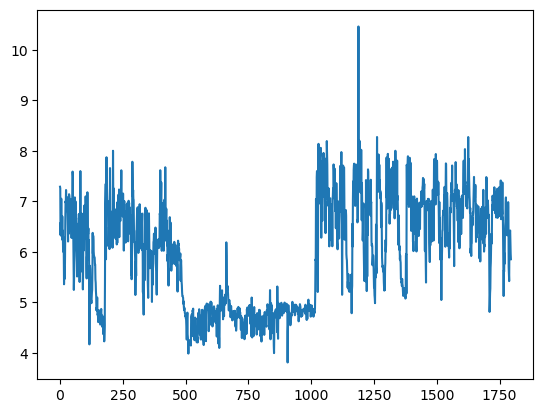

In [92]:
plt.plot(float_shift[:,2])